# Eye Tracking Data Analysis Project

This project is prepared for BDA 502 - Introduction to Machine Learning Course

Group Members:

    * YUDUM PAÇİN
    * YIĞIT ONAY 
    * EGEMEN ONAT ATAM 
    * HACI BAYRAM SAYGILI 
    * ARDA TANRIVERDI

## Table of Contents:
* [Data](#first-bullet)
* [Data Preprocess](#second-bullet)
* [Statistical Analysis](#second-bullet)
* [Machine Learning](#second-bullet)

Eye Tracking Data source, given [link](https://drive.google.com/drive/folders/1-IONyJb2HClD2KfeJtVgrsV4IMwJsd26?usp=share_link) is in csv formatted 80 files with approximately 50000 rows for each, consisting of participants of Eye Tracking Experiment.

[Eye_Tracking_Data.ipynb](http://localhost:8888/notebooks/Documents/GitHub/eye_tracking_data_project/eye_tracking_data_project/Eye_Tracking_Data.ipynb) file consists of codes we used for downloading these csv files, converting them to Pandas dataframes and saving it as pickles. 

In this file, data preprocess steps below are applied before saving the file.


* TIME, FPOGX, FPOGY, FPOGS, FPOGD, FPOGID, FPOGV, LPUPILD, LPUPILV, RPUPILD, RPUPILV, USER columns kept
* Any values that do not contain STIMULI_ONSET string under the USER column were deleted.


In these part of the analysis, we continue to data analysis of eye tracking data step by step

In [92]:
#import necessary libraries
import pickle
import bz2
import gzip
import lzma
import pickle
import numpy as np
import pandas as pd
import math
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

### emrec_data: summary of participant informations

In [93]:
#load the summary participant data
with open('emorec_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [94]:
data.head()

,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
0,1,28,F,control,67.600,0.970,High IAcc,0.850,0.570,0.500,0.500,2.420
1,2,28,F,self,75.600,0.750,High IAcc,0.500,0.600,0.450,0.500,2.050
2,3,25,F,self,75.000,0.700,High IAcc,1.000,0.870,0.370,0.000,2.240
3,4,26,F,self,84.300,0.910,High IAcc,0.550,0.220,0.420,0.140,1.330
4,5,30,F,self,67.300,0.810,High IAcc,0.600,0.420,0.370,0.420,1.810


In [95]:
data.shape

(80, 12)

### participants data: eye tracking experiments data of all participants

In [96]:
# open participants_compressed.pbz2
with bz2.open('participants_compressed.pbz2', 'rb') as f:
    participants = pickle.load(f)

In [97]:
participants.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2884,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2885,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2886,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2887,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e


In [98]:
participants.shape

(3409501, 13)

In [279]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3409501 entries, 2883 to 4190093
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   TIME      float64
 1   FPOGX     object 
 2   FPOGY     float64
 3   FPOGS     float64
 4   FPOGD     float64
 5   FPOGID    float64
 6   FPOGV     float64
 7   LPUPILD   float64
 8   LPUPILV   float64
 9   RPUPILD   float64
 10  RPUPILV   float64
 11  USER      object 
 12  FileName  object 
dtypes: float64(10), object(3)
memory usage: 364.2+ MB


In [280]:
participants.FPOGX = participants.FPOGX.astype("float")

In [282]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3409501 entries, 2883 to 4190093
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   TIME      float64
 1   FPOGX     float64
 2   FPOGY     float64
 3   FPOGS     float64
 4   FPOGD     float64
 5   FPOGID    float64
 6   FPOGV     float64
 7   LPUPILD   float64
 8   LPUPILV   float64
 9   RPUPILD   float64
 10  RPUPILV   float64
 11  USER      object 
 12  FileName  object 
dtypes: float64(11), object(2)
memory usage: 364.2+ MB


In [283]:
participants.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2884,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2885,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2886,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2887,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e


In [281]:
len(np.unique(participants.FileName)) * len(np.unique(participants.USER)) 

2560

In [286]:
participants.query("FileName=='emorec_ctrlm2427_e'")

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
1056319,200.110,0.337,0.321,199.735,0.128,388.000,0.000,0.003,1.000,0.003,1.000,STIMULI_ONSET1,emorec_ctrlm2427_e
1056320,200.125,0.503,0.484,199.735,0.128,388.000,0.000,0.003,1.000,0.003,1.000,STIMULI_ONSET1,emorec_ctrlm2427_e
1056321,200.143,0.503,0.490,199.735,0.128,388.000,0.000,0.003,1.000,0.003,1.000,STIMULI_ONSET1,emorec_ctrlm2427_e
1056322,200.159,0.503,0.492,199.735,0.128,388.000,0.000,0.003,1.000,0.003,1.000,STIMULI_ONSET1,emorec_ctrlm2427_e
1056323,200.175,0.508,0.491,200.125,0.049,389.000,1.000,0.003,1.000,0.003,1.000,STIMULI_ONSET1,emorec_ctrlm2427_e
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101471,940.880,0.486,0.267,940.536,0.344,1313.000,1.000,0.003,1.000,0.003,1.000,STIMULI_ONSET32,emorec_ctrlm2427_e
1101472,940.896,0.486,0.266,940.536,0.360,1313.000,1.000,0.004,1.000,0.003,1.000,STIMULI_ONSET32,emorec_ctrlm2427_e
1101473,940.914,0.487,0.265,940.536,0.378,1313.000,1.000,0.003,1.000,0.004,1.000,STIMULI_ONSET32,emorec_ctrlm2427_e
1101474,940.930,0.488,0.266,940.536,0.394,1313.000,1.000,0.003,1.000,0.004,1.000,STIMULI_ONSET32,emorec_ctrlm2427_e


### sample data

In [100]:
sample_data = pd.read_excel("Sample Analyses_507.xlsx")

In [101]:
sample_data.head()

,PARTICIPANT,GROUP (Control or self),STIMULI,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY,DURATION,FIXATION_VALIDATION,TOTAL_FIXATION_DURATION,FIXATION_DURATION_PER_COUNT,TOTAL_FIXATION_COUNT,PUPIL_DILATION,RIGHT_PUPIL_DILATION_VALIDATION,LEFT_PUPIL_DILATION_VALIDATION,TOTAL_SACCADE/SECOND
0,1,control,1,High,F,SAD,SAD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,control,2,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,control,3,High,F,ANGRY,ANGRY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,control,4,High,F,ANGRY,NEUTRAL,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,control,5,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
sample_data.shape

(2208, 17)

## Preprocess the Data

In [103]:
# Validating if ratio of valid data is above 70% - possible exclusion of users.
validate_fpogv = participants.groupby(["FileName","USER"])["FPOGV"].mean().reset_index()
validate_fpogv.head()

,FileName,USER,FPOGV
0,emorecF1029_e,STIMULI_ONSET1,0.698
1,emorecF1029_e,STIMULI_ONSET10,0.726
2,emorecF1029_e,STIMULI_ONSET11,0.732
3,emorecF1029_e,STIMULI_ONSET12,0.735
4,emorecF1029_e,STIMULI_ONSET13,0.692


In [104]:
validate_fpogv_valids = validate_fpogv[validate_fpogv["FPOGV"]>0.7]
validate_fpogv_valids.head()

,FileName,USER,FPOGV
1,emorecF1029_e,STIMULI_ONSET10,0.726
2,emorecF1029_e,STIMULI_ONSET11,0.732
3,emorecF1029_e,STIMULI_ONSET12,0.735
5,emorecF1029_e,STIMULI_ONSET14,0.746
6,emorecF1029_e,STIMULI_ONSET15,0.802


In [105]:
#filter the data
data_filtered = participants[(participants.FileName.isin(validate_fpogv_valids.FileName)) & (participants.USER.isin(validate_fpogv_valids.USER))]

In [106]:
# Filtering with respect to non-null values of FPOGV, LPUPILV and RPUPILV
data_filtered_2 = data_filtered.query("(FPOGV == 1) & (LPUPILV == 1) & (RPUPILV == 1)").copy()

In [107]:
#get the final preprocessed data
df_prep = data_filtered_2.copy()

In [108]:
df_prep.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2884,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2885,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2886,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2887,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e


## The Butterworth low-pass filter

In [109]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 3                                               #
#                                                            #
##############################################################

from sklearn.decomposition import PCA

from scipy.signal import butter, lfilter, filtfilt

def low_pass_filter(data_table, col, sampling_frequency, cutoff_frequency, order=5, phase_shift=True):
    # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
    nyq = 0.5 * sampling_frequency
    cut = cutoff_frequency / nyq

    b, a = butter(order, cut, btype='low', output='ba', analog=False)
    if phase_shift:
        data_table[col + '_lowpass'] = filtfilt(b, a, data_table[col])
    else:
        data_table[col + '_lowpass'] = lfilter(b, a, data_table[col])
    return data_table

In [110]:
df_prep["max_pupild"] = df_prep[["LPUPILD", "RPUPILD"]].max(axis=1)
fs = 60
cutoff = 0.5
fs = 1000/200
cutoff = 1
df_low_pass_final = low_pass_filter(df_prep.groupby("USER").mean(),"max_pupild", fs, cutoff)[["max_pupild", "max_pupild_lowpass"]]

## Calculate z-scores

<AxesSubplot:xlabel='USER'>

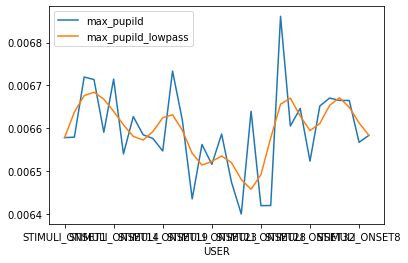

In [111]:
df_low_pass_final["z_score"] = (df_low_pass_final["max_pupild"] - np.mean(df_low_pass_final["max_pupild"])) / np.std(df_low_pass_final["max_pupild"])
df_low_pass_final[["max_pupild", "max_pupild_lowpass"]].plot()

<AxesSubplot:xlabel='USER'>

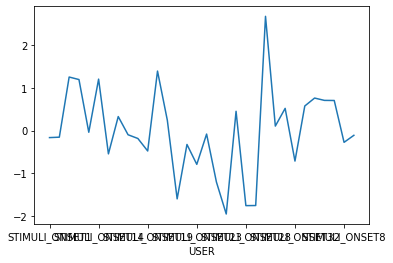

In [112]:
df_low_pass_final["z_score"].plot()

## Calculate And Add Fixation Count and Fixation Duration

In [113]:
def calculate_fixation_count(df):
    data = df.copy()
    data = data.sort_values(["USER","TIME"])

    # Specify fixation radius and minimum duration
    fixation_radius = 58
    min_duration = 0.12
    #create an empty list for storing results
    results = []

    # Get unique trial names
    trials = data['USER'].unique()
    participants = data["FileName"].unique()

    # Loop through files, e.g.'emorec_ctrlm2427.xlsx'
    for participant in participants:
        # Loop through trials and calculate fixation count and duration
        for trial in trials:
             #create an empty list for storing fixation count and duration
            result = {}
            trial_data = data[data['USER'] == trial]
            fixation_count = 0
            fixation_duration = 0
            last_fixation_end_time = float('nan')
            last_x = last_y = 0

            for index, row in trial_data.iterrows():
                
                x = row['FPOGX'] * 1920  # Convert fraction of screen to pixels
                y = row['FPOGY'] * 1080  # Convert fraction of screen to pixels

                if math.isnan(last_fixation_end_time):
                    # First sample in trial
                    fixation_start_time = row['FPOGS']
                    last_fixation_end_time = fixation_start_time
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                        row['FPOGS'] - last_fixation_end_time <= min_duration:
                    # Continuing fixation
                    pass
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                        row['FPOGS'] - last_fixation_end_time > min_duration:
                    # Extended fixation
                    fixation_duration += row['FPOGS'] - last_fixation_end_time
                    last_fixation_end_time = row['FPOGS'] + row['FPOGD']
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) > fixation_radius:
                    # New fixation
                    fixation_count += 1
                    fixation_duration += row['FPOGD']
                    fixation_start_time = row['FPOGS']
                    last_fixation_end_time = row['FPOGS'] + row['FPOGD']

                last_x = x
                last_y = y

            # Print results for trial
            #print(f"Trial: {trial}, Fixation Count: {fixation_count}, Fixation Duration: {fixation_duration:.2f} seconds")
            result["trial"] = trial
            result["FileName"] = participant
            result["fixation_count"] = fixation_count
            result["fixation_duration"] = fixation_duration
            results.append(result)
        
    
    return results

In [114]:
results = calculate_fixation_count(df_prep)

In [115]:
results_df = pd.DataFrame(results)

In [116]:
df_fix = pd.merge(results_df, df_prep, left_on=["trial","FileName"], right_on = ["USER","FileName"])

In [117]:
df_fix.head()

,trial,FileName,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,max_pupild
0,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.905,0.500,0.479,125.728,0.177,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
1,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.920,0.501,0.478,125.728,0.193,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
2,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.938,0.501,0.477,125.728,0.210,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
3,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.953,0.500,0.475,125.728,0.226,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
4,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.969,0.500,0.475,125.728,0.242,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006


## Statistical Analysis

1.	Participants with high vs low interoceptive awareness (ANOVA, Post-hoc, T-Tests, Correlation)

* Differences in eye behaviors (fixation counts, fixation duration) between two groups for all trials, conditions, gender and accuracy scores. 

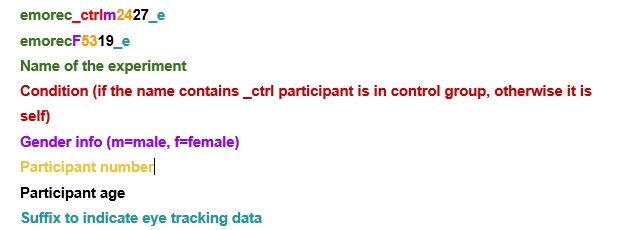

### Prepare the data for Statistical Analysis

### Merge participant data with emorec_data

In [118]:
data.head()

,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
0,1,28,F,control,67.600,0.970,High IAcc,0.850,0.570,0.500,0.500,2.420
1,2,28,F,self,75.600,0.750,High IAcc,0.500,0.600,0.450,0.500,2.050
2,3,25,F,self,75.000,0.700,High IAcc,1.000,0.870,0.370,0.000,2.240
3,4,26,F,self,84.300,0.910,High IAcc,0.550,0.220,0.420,0.140,1.330
4,5,30,F,self,67.300,0.810,High IAcc,0.600,0.420,0.370,0.420,1.810


In [119]:
#create a FileName column from emorec data
data["FileName"] = "emorec" + data.apply(lambda row: "_ctrl" if row["condition"] =="control" else '', axis=1)+data.apply(lambda row: 'F' if row["subgender"]=='F' else 'm',axis=1)+data.subid.astype("str")+data.subage.astype("str")+"_e"

In [120]:
#to merge our data and emorec data lower the FileName columns
data["FileName"] = data["FileName"].str.lower()
df_fix["FileName"] = df_fix["FileName"].str.lower()

In [291]:
#merge the emorec data and our data
df_tam = pd.merge(df_fix,data, left_on="FileName", right_on="FileName")

In [292]:
pd.set_option('display.max_columns', None)

In [293]:
#There are 83 different files, participants
np.unique(df_tam.subid.value_counts().index)

array([ 1,  2,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21,
       22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76,
       78, 79, 80, 81, 82, 83], dtype=int64)

In [294]:
#list a participant data for control
df_tam[df_tam.FileName=='emorecm4623_e'].sort_values(by="TIME")

,trial,FileName,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,max_pupild,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
71139,STIMULI_ONSET1,emorecm4623_e,72220,36525.142,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71140,STIMULI_ONSET1,emorecm4623_e,72220,36525.142,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71141,STIMULI_ONSET1,emorecm4623_e,72220,36525.142,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71142,STIMULI_ONSET1,emorecm4623_e,72220,36525.142,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71143,STIMULI_ONSET1,emorecm4623_e,72220,36525.142,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91035,STIMULI_ONSET32,emorecm4623_e,58787,22140.924,839.501,0.526,0.425,839.304,0.197,1469.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET32,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
91036,STIMULI_ONSET32,emorecm4623_e,58787,22140.924,839.518,0.526,0.424,839.304,0.213,1469.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET32,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
91037,STIMULI_ONSET32,emorecm4623_e,58787,22140.924,839.536,0.526,0.422,839.304,0.232,1469.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET32,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
91038,STIMULI_ONSET32,emorecm4623_e,58787,22140.924,839.550,0.527,0.419,839.304,0.246,1469.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET32,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210


In [295]:
#create STIMULI column from USER column
df_tam["STIMULI"] = df_tam["USER"].str.replace("STIMULI_ONSET","").astype("int")

In [288]:
df_tam.head()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation,GROUP,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,0.506,1933.000,control,High,F,SAD,SAD,1
1,1,2,8.214,435.000,13914475.922,29209815,435.000,435.000,0.476,435.000,control,High,F,HAPPY,HAPPY,1
2,1,3,10.137,546.000,15747822.194,32305728,546.000,546.000,0.487,546.000,control,High,F,ANGRY,ANGRY,1
3,1,4,7.344,394.000,12431842.340,25678162,394.000,394.000,0.484,394.000,control,High,F,ANGRY,NEUTRAL,0
4,1,5,8.115,417.000,11740240.009,25791867,417.000,417.000,0.455,417.000,control,High,F,HAPPY,HAPPY,1


In [296]:
df_tam.shape

(2371004, 30)

In [128]:
#Sort the whole data by STIMULI and TIME
df_tam = df_tam.sort_values(['STIMULI', 'TIME'])

In [298]:
#group df_tam by the "subid"(participant) and "STIMULI"(trial) and calculate the values
results = df_tam.groupby(["subid","STIMULI"]).agg({
    'TIME': [('DURATION', lambda x: x.iloc[-1] - x.iloc[0])],
    'FPOGV': [('fixation_validation', lambda x: x.mean())],
    'fixation_duration': [('total_fixation_duration', lambda x: x.mean())],
    'fixation_count': [('total_fixation_count', lambda x: x.mean())],
    'RPUPILV': [('right_pupil_dilation_validation', lambda x: x.mean())],
    'LPUPILV': [('left_pupil_dilation_validation', lambda x: x.mean())]
}).copy()

In [299]:
#rename the columns
results.columns = [col[0] if col[-1] == '' else col[-1] for col in results.columns]

In [300]:
results = results.reset_index()

In [301]:
results.head()

,subid,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000


In [302]:
#calculate fixation_duration_per_count
results = results.eval("fixation_duration_per_count = total_fixation_duration / total_fixation_count")

In [303]:
results.head()

,subid,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000,0.506
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000,0.476
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000,0.487
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000,0.484
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000,0.455


In [371]:
results.fixation_validation.value_counts()

1.000    2362
Name: fixation_validation, dtype: int64

In [304]:
results.rename(columns={"subid":"PARTICIPANT"},inplace=True)

In [305]:
results.to_pickle("results_son.pkl")

In [309]:
results = pd.read_pickle("results_son.pkl")

In [310]:
#calculate pupil_dilation
results["pupil_dilation"] = results.groupby(["PARTICIPANT","STIMULI"])[['right_pupil_dilation_validation','left_pupil_dilation_validation']].mean().reset_index()["right_pupil_dilation_validation"]

In [311]:
results.head()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000,0.506,1.000
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000,0.476,1.000
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000,0.487,1.000
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000,0.484,1.000
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000,0.455,1.000


#### Data should be in below format

In [312]:
#Sample data;
sample_data.head()

,PARTICIPANT,GROUP (Control or self),STIMULI,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY,DURATION,FIXATION_VALIDATION,TOTAL_FIXATION_DURATION,FIXATION_DURATION_PER_COUNT,TOTAL_FIXATION_COUNT,PUPIL_DILATION,RIGHT_PUPIL_DILATION_VALIDATION,LEFT_PUPIL_DILATION_VALIDATION,TOTAL_SACCADE/SECOND
0,1,control,1,High,F,SAD,SAD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,control,2,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,control,3,High,F,ANGRY,ANGRY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,control,4,High,F,ANGRY,NEUTRAL,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,control,5,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
#Our data;
results.head()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000,0.506,1.000
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000,0.476,1.000
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000,0.487,1.000
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000,0.484,1.000
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000,0.455,1.000


In [314]:
kalacaklar = sample_data.columns[~sample_data.isna().any()].values.tolist()

In [315]:
df_sub_tam = pd.merge(results,sample_data[kalacaklar],left_on = ["PARTICIPANT","STIMULI"],right_on=["PARTICIPANT","STIMULI"])

In [316]:
df_tam_ = df_sub_tam.copy()

In [317]:
df_tam_.rename(columns={"GROUP (Control or self)":"GROUP"},inplace=True)

In [318]:
#save the data as pkl
df_tam_.to_pickle("statistics.pkl")

In [319]:
df_tam_ = pd.read_pickle("statistics.pkl")

In [320]:
df_tam_.head()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation,GROUP,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000,0.506,1.000,control,High,F,SAD,SAD,1
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000,0.476,1.000,control,High,F,HAPPY,HAPPY,1
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000,0.487,1.000,control,High,F,ANGRY,ANGRY,1
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000,0.484,1.000,control,High,F,ANGRY,NEUTRAL,0
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000,0.455,1.000,control,High,F,HAPPY,HAPPY,1


In [321]:
df_tam_.query("(PARTICIPANT==24) & (STIMULI==1)").T

,576
PARTICIPANT,24
STIMULI,1
DURATION,19.831
fixation_validation,1.000
total_fixation_duration,36525.142
total_fixation_count,72220.000
right_pupil_dilation_validation,1.000
left_pupil_dilation_validation,1.000
fixation_duration_per_count,0.506
pupil_dilation,1.000


## Statistical Analysis

1.	Participants with high vs low interoceptive awareness (ANOVA, Post-hoc, T-Tests, Correlation)

●	Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, gender and accuracy scores. 

In [322]:
df_tam_.select_dtypes("object").describe()

,GROUP,TYPE,GENDER,EMOTION,RESPONSE
count,2138,2138,2138,2138,2138
unique,2,2,2,4,4
top,control,High,M,ANGRY,HAPPY
freq,1082,1117,1181,543,672


Text(0.5, 1.0, 'Distribution of group control and self')

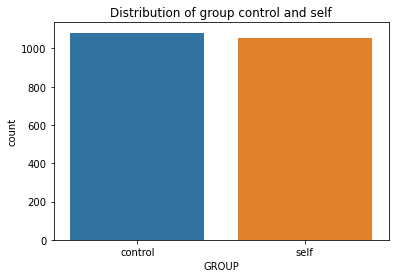

In [323]:
sns.countplot(x="GROUP",data=df_tam_)
plt.title("Distribution of group control and self")

In [324]:
df_tam_.columns

Index(['PARTICIPANT', 'STIMULI', 'DURATION', 'fixation_validation',
       'total_fixation_duration', 'total_fixation_count',
       'right_pupil_dilation_validation', 'left_pupil_dilation_validation',
       'fixation_duration_per_count', 'pupil_dilation', 'GROUP', 'TYPE',
       'GENDER', 'EMOTION', 'RESPONSE', 'ACCURACY'],
      dtype='object')

In [325]:
df_tam_.groupby(["GROUP"])["total_fixation_count","total_fixation_duration"].mean().T

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7300\3154829746.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam_.groupby(["GROUP"])["total_fixation_count","total_fixation_duration"].mean().T


GROUP,control,self
total_fixation_count,64800.307,64787.750
total_fixation_duration,27453.181,27455.830


Actually, total_fixation_count and total_fixation_duration have similar means by groups

Let's look at distributions of total fixation count and durations. If it is normal distribution we can apply t-test for comparing means.

In [326]:
group_control = df_tam_[df_tam_['GROUP'] == 'control']
group_self = df_tam_[df_tam_['GROUP'] == 'self']

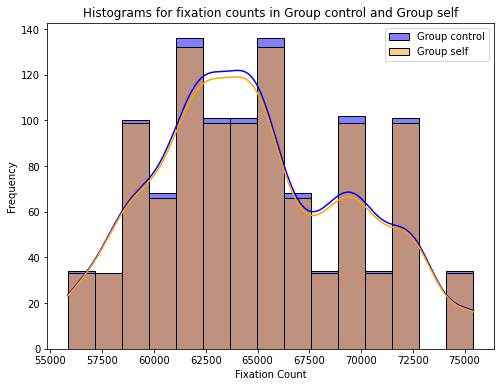

In [327]:
# Create histograms for fixation counts in Group 1 and Group 2
plt.figure(figsize=(8, 6))
sns.histplot(data=group_control, x='total_fixation_count', kde=True, color='blue', label='Group control')
sns.histplot(data=group_self, x='total_fixation_count', kde=True, color='orange', label='Group self')
plt.xlabel('Fixation Count')
plt.ylabel('Frequency')
plt.title('Histograms for fixation counts in Group control and Group self')
plt.legend()
plt.show()

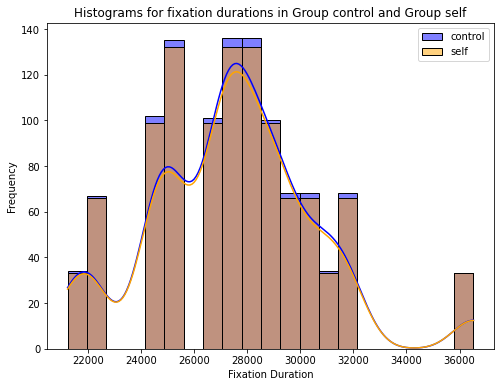

In [328]:
# Create histograms for fixation counts in Group comtrol and Group self
plt.figure(figsize=(8, 6))
sns.histplot(data=group_control, x='total_fixation_duration', kde=True, color='blue', label='control')
sns.histplot(data=group_self, x='total_fixation_duration', kde=True, color='orange', label='self')
plt.xlabel('Fixation Duration')
plt.ylabel('Frequency')
plt.title('Histograms for fixation durations in Group control and Group self')
plt.legend()
plt.show()

Distiributions are similar to normal distribution, i will use t-test

In [329]:
import scipy.stats as stats

In [330]:
# Perform t-tests for fixation counts, fixation duration, and saccades per second
ttest_counts = stats.ttest_ind(group_control['total_fixation_count'], group_self['total_fixation_count'])
ttest_duration = stats.ttest_ind(group_control['total_fixation_duration'], group_self['total_fixation_duration'])

In [331]:
# Print the results
print("T-Tests:")
print(f"Fixation Count: t-value = {ttest_counts.statistic:.4f}, p-value = {ttest_counts.pvalue:.4f}")
print(f"Fixation Duration: t-value = {ttest_duration.statistic:.4f}, p-value = {ttest_duration.pvalue:.4f}")


T-Tests:
Fixation Count: t-value = 0.0607, p-value = 0.9516
Fixation Duration: t-value = -0.0197, p-value = 0.9843


**Results**: Two of the p-value is greater than 0.05, so we do not have strong evidence to reject the null hypothesis and claim a significant difference in the means of Fixation Duration& Fixation count between the two groups.


●	Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for accurate trials.

In [332]:
df_tam_.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration"].describe().T

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7300\1844168949.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam_.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration"].describe().T


GROUP                           control      self
total_fixation_count    count   512.000   499.000
                        mean  64794.385 64541.024
                        std    4743.817  4625.231
                        min   55827.000 55827.000
                        25%   61697.500 61851.000
                        50%   63954.000 63954.000
                        75%   69005.000 68280.000
                        max   75430.000 75430.000
total_fixation_duration count   512.000   499.000
                        mean  27367.740 27255.431
                        std    3047.718  3004.140
                        min   21222.064 21222.064
                        25%   24917.319 24917.319
                        50%   27271.453 27271.453
                        75%   29180.400 29011.283
                        max   36525.142 36525.142

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7300\1033326748.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam_.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration"].mean().plot(kind="bar")


<AxesSubplot:xlabel='GROUP'>

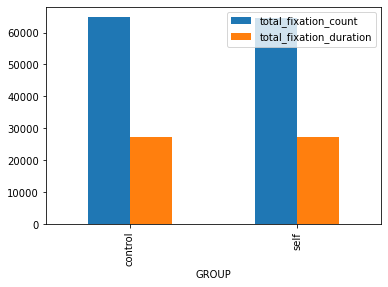

In [333]:
df_tam_.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration"].mean().plot(kind="bar")

In [334]:
group_control_acc = df_tam_.query("(ACCURACY==1) & (GROUP=='control')")
group_self_acc = df_tam_.query("(ACCURACY==1) & (GROUP=='self')")

In [335]:
# Perform t-tests for fixation counts, fixation duration, and saccades per second
ttest_counts_acc = stats.ttest_ind(group_control_acc['total_fixation_count'], group_self_acc['total_fixation_count'])
ttest_duration_acc = stats.ttest_ind(group_control_acc['total_fixation_duration'], group_self_acc['total_fixation_duration'])

In [336]:
# Print the results
print("T-Tests:")
print(f"Fixation Count: t-value = {ttest_counts_acc.statistic:.4f}, p-value = {ttest_counts_acc.pvalue:.4f}")
print(f"Fixation Duration: t-value = {ttest_duration_acc.statistic:.4f}, p-value = {ttest_duration_acc.pvalue:.4f}")


T-Tests:
Fixation Count: t-value = 0.8596, p-value = 0.3902
Fixation Duration: t-value = 0.5899, p-value = 0.5554


**Results**: Two of the p-value is greater than 0.05, so we do not have strong evidence to reject the null hypothesis and claim a significant difference in the means of Fixation Duration& Fixation count between the two groups. 
This result is much stronger than former one since p-values are greater.

2.	Main effects and interactions in terms of eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, genders and accuracy scores. (ANOVA, Post hoc, T-Tests, Correlation)

In [337]:
korr = df_tam_.corr(method="spearman")

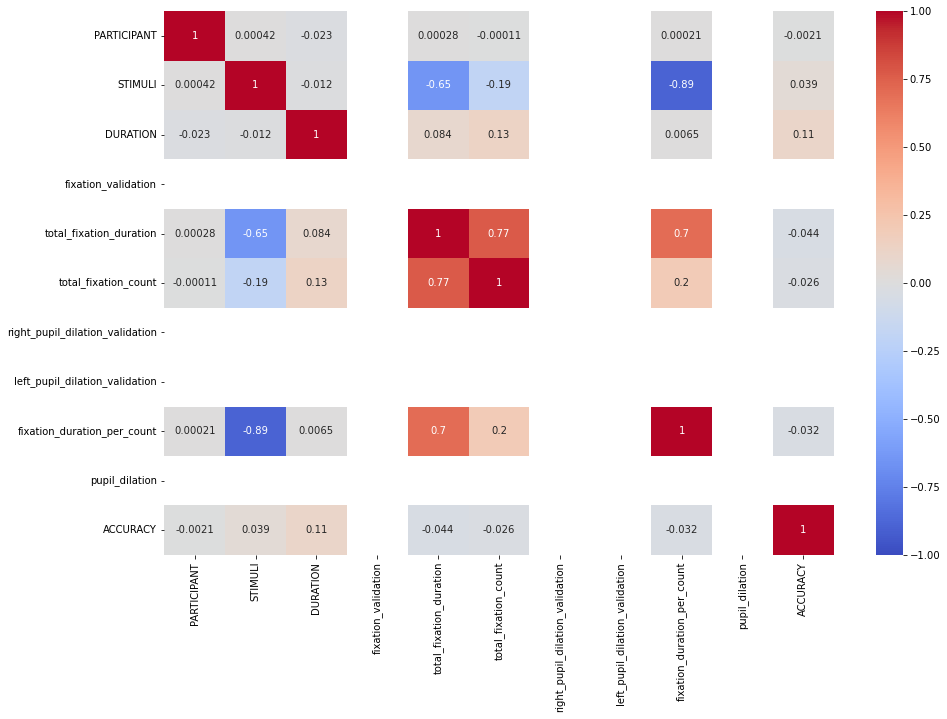

In [338]:
plt.figure(figsize = (15,10))
sns.heatmap(korr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [339]:
korr_table = korr[["fixation_validation","total_fixation_duration","total_fixation_count"]]

In [340]:
korr_table

,fixation_validation,total_fixation_duration,total_fixation_count
PARTICIPANT,NaN,0.000,-0.000
STIMULI,NaN,-0.651,-0.189
DURATION,NaN,0.084,0.125
fixation_validation,NaN,NaN,NaN
total_fixation_duration,NaN,1.000,0.772
total_fixation_count,NaN,0.772,1.000
right_pupil_dilation_validation,NaN,NaN,NaN
left_pupil_dilation_validation,NaN,NaN,NaN
fixation_duration_per_count,NaN,0.698,0.200
pupil_dilation,NaN,NaN,NaN


**Correlated features:**

In [341]:
# Set a correlation threshold (absolute value) for considering features as highly correlated
correlation_threshold = 0.5

# Find highly correlated features and their correlations
highly_correlated_features = []
for i in range(len(korr_table.columns)):
    for j in range(i):
        if abs(korr_table.iloc[i, j]) > correlation_threshold:
            feature_i = korr_table.columns[i]
            feature_j = korr_table.columns[j]
            correlation_value = korr_table.iloc[i, j]
            highly_correlated_features.append((feature_i, feature_j, correlation_value))

# Display highly correlated features and their correlations
for feature_i, feature_j, correlation_value in highly_correlated_features:
    print(f"{feature_i} - {feature_j}: {correlation_value}")

In [342]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [343]:
# Define the ANOVA model using the formula interface
model = ols('fixation_duration_per_count ~ GROUP', data=df_tam_).fit()

# Print ANOVA table
print(sm.stats.anova_lm(model, typ=2))

          sum_sq       df     F  PR(>F)
GROUP      0.000    1.000 0.008   0.929
Residual   2.133 2136.000   NaN     NaN


In [344]:
# Define the ANOVA model using the formula interface
model = ols('total_fixation_count ~ GROUP', data=df_tam_).fit()

# Print ANOVA table
print(sm.stats.anova_lm(model, typ=2))

                  sum_sq       df     F  PR(>F)
GROUP          84264.402    1.000 0.004   0.952
Residual 48907030140.129 2136.000   NaN     NaN


Since the p-value is greater than 0.05 for all tests hence we cannot reject the null hypothesis. 
This implies that we have not sufficient proof to say that there exists a difference in the (fixation counts, fixation duration among 2 different groups

## Machine Learning Application

In [345]:
df_tam_.isna().sum()

PARTICIPANT                        0
STIMULI                            0
DURATION                           0
fixation_validation                0
total_fixation_duration            0
total_fixation_count               0
right_pupil_dilation_validation    0
left_pupil_dilation_validation     0
fixation_duration_per_count        0
pupil_dilation                     0
GROUP                              0
TYPE                               0
GENDER                             0
EMOTION                            0
RESPONSE                           0
ACCURACY                           0
dtype: int64

In [346]:
df_tam_.duplicated().sum()

0

In [347]:
df_tam_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2137
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PARTICIPANT                      2138 non-null   int64  
 1   STIMULI                          2138 non-null   int64  
 2   DURATION                         2138 non-null   float64
 3   fixation_validation              2138 non-null   float64
 4   total_fixation_duration          2138 non-null   float64
 5   total_fixation_count             2138 non-null   float64
 6   right_pupil_dilation_validation  2138 non-null   float64
 7   left_pupil_dilation_validation   2138 non-null   float64
 8   fixation_duration_per_count      2138 non-null   float64
 9   pupil_dilation                   2138 non-null   float64
 10  GROUP                            2138 non-null   object 
 11  TYPE                             2138 non-null   object 
 12  GENDER              

In [348]:
df_tam_.describe()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation,ACCURACY
count,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000
mean,42.714,16.512,21.598,1.000,27454.489,64794.105,1.000,1.000,0.423,1.000,0.473
std,23.750,9.227,10.103,0.000,3109.481,4783.918,0.000,0.000,0.032,0.000,0.499
min,1.000,1.000,0.133,1.000,21222.064,55827.000,1.000,1.000,0.377,1.000,0.000
25%,22.000,9.000,10.166,1.000,25493.818,61851.000,1.000,1.000,0.407,1.000,0.000
50%,43.000,17.000,20.191,1.000,27331.832,64885.000,1.000,1.000,0.417,1.000,0.000
75%,64.000,24.750,29.670,1.000,29344.908,68823.750,1.000,1.000,0.431,1.000,1.000
max,83.000,32.000,37.330,1.000,36525.142,75430.000,1.000,1.000,0.506,1.000,1.000


In [349]:
#Split the data

In [350]:
y = df_tam_.RESPONSE

In [351]:
y.value_counts()

HAPPY      672
NEUTRAL    581
SAD        522
ANGRY      363
Name: RESPONSE, dtype: int64

In [352]:
X = df_tam_.drop(["RESPONSE"],axis=1)

In [353]:
X.head()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation,GROUP,TYPE,GENDER,EMOTION,ACCURACY
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000,0.506,1.000,control,High,F,SAD,1
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000,0.476,1.000,control,High,F,HAPPY,1
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000,0.487,1.000,control,High,F,ANGRY,1
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000,0.484,1.000,control,High,F,ANGRY,0
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000,0.455,1.000,control,High,F,HAPPY,1


In [354]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2137
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PARTICIPANT                      2138 non-null   int64  
 1   STIMULI                          2138 non-null   int64  
 2   DURATION                         2138 non-null   float64
 3   fixation_validation              2138 non-null   float64
 4   total_fixation_duration          2138 non-null   float64
 5   total_fixation_count             2138 non-null   float64
 6   right_pupil_dilation_validation  2138 non-null   float64
 7   left_pupil_dilation_validation   2138 non-null   float64
 8   fixation_duration_per_count      2138 non-null   float64
 9   pupil_dilation                   2138 non-null   float64
 10  GROUP                            2138 non-null   object 
 11  TYPE                             2138 non-null   object 
 12  GENDER              

In [355]:
X_cat = pd.get_dummies(X,drop_first=True)

In [356]:
X_cat.head()

,PARTICIPANT,STIMULI,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,fixation_duration_per_count,pupil_dilation,ACCURACY,GROUP_self,TYPE_Low,GENDER_M,EMOTION_HAPPY,EMOTION_NEUTRAL,EMOTION_SAD
0,1,1,35.732,1.000,36525.142,72220.000,1.000,1.000,0.506,1.000,1,0,0,0,0,0,1
1,1,2,8.214,1.000,31987.301,67149.000,1.000,1.000,0.476,1.000,1,0,0,0,1,0,0
2,1,3,10.137,1.000,28842.165,59168.000,1.000,1.000,0.487,1.000,1,0,0,0,0,0,0
3,1,4,7.344,1.000,31552.899,65173.000,1.000,1.000,0.484,1.000,0,0,0,0,0,0,0
4,1,5,8.115,1.000,28154.053,61851.000,1.000,1.000,0.455,1.000,1,0,0,0,1,0,0


In [357]:
from sklearn.model_selection import train_test_split

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X_cat,y,test_size=0.2,random_state=0)

In [359]:
#Build the classification model

In [360]:
import lightgbm

In [361]:
from lightgbm import LGBMClassifier

In [362]:
model = LGBMClassifier()

In [363]:
model.fit(X_train,y_train)

LGBMClassifier()

In [364]:
y_pred = model.predict(X_test)

In [365]:
from sklearn.metrics import confusion_matrix,classification_report

In [366]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       ANGRY       0.80      0.55      0.65        88
       HAPPY       0.83      0.92      0.87       128
     NEUTRAL       0.76      0.74      0.75       115
         SAD       0.73      0.86      0.79        97

    accuracy                           0.78       428
   macro avg       0.78      0.77      0.76       428
weighted avg       0.78      0.78      0.77       428



In [367]:
confusion_matrix(y_test,y_pred)

array([[ 48,   7,  18,  15],
       [  1, 118,   5,   4],
       [  6,  13,  85,  11],
       [  5,   5,   4,  83]], dtype=int64)

In [368]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)

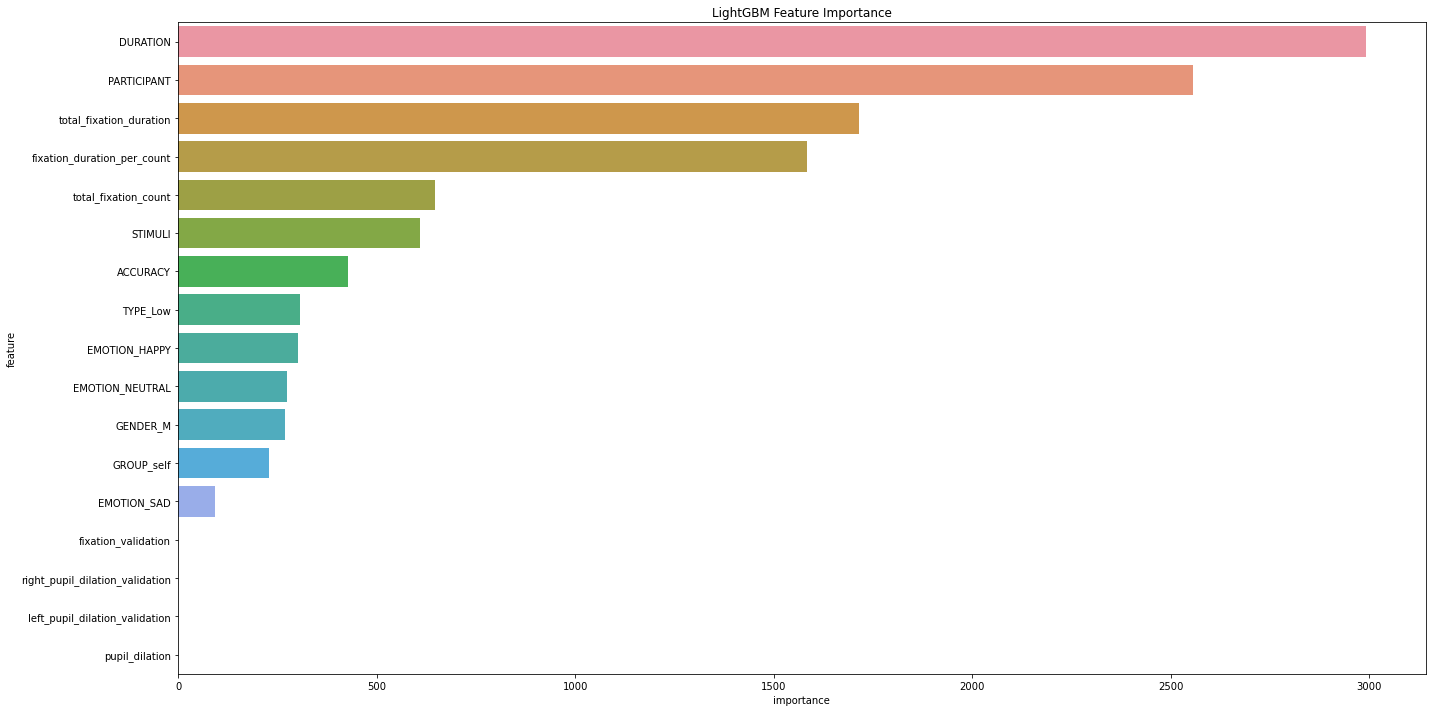

In [369]:
plt.figure(figsize=(20, 10))
sns.barplot(y=df_feature_importance.feature, x=df_feature_importance.importance, data=df_feature_importance.sort_values(by="importance", 
                                                        ascending=False), orient='h')

plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()